In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random

In [ ]:
#Hodgkin-Huxley Model

# Average potassium channel conductance per unit area (mS/cm^2)
gK = 36.0
# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0
# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3
# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0
# Potassium potential (mV)
VK = -12.0
# Sodium potential (mV)
VNa = 115.0
# Leak potential (mV)
Vl = 10.613
# Inhibition constant
InhibitionConst = 10

# Potassium ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

# Sodium ion-channel rate functions

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
  
# n, m, and h steady-state values

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

# Input stimulus
def Id(t, stim):
  if (stim=='blue'):
    frequency = 6.66
    amplitude = 20
    theta = 0
    return amplitude * np.sin(2 * np.pi * frequency * t*0.001)
    
  elif (stim=='yellow'):
    frequency = 5.16
    amplitude = 20
    theta = 0
    return amplitude * np.sin(2 * np.pi * frequency * t*0.001)

  if (stim=='hgrate'):
    frequency = 8
    amplitude = 20
    theta = 0
    return amplitude * np.sin(2 * np.pi * frequency * t*0.001)
    
  elif (stim=='vgrate'):
    frequency = 10
    amplitude = 20
    theta = 0
    return amplitude * np.sin(2 * np.pi * frequency * t*0.001)
  
  else:
    return('StimulusInvalid')

# Compute derivatives
def compute_derivatives(y, t0, stim):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (Id(t0,stim) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

def compute_derivativesKN(y, t0, KNin):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (KNin[int(t0)] / (InhibitionConst*Cm)) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

#Params

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 1000.0

# Time values
T = np.arange(tmin, tmax, 1)
  
# State (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])

np.random.seed(42)
noise=[]
for i in range(len(T)):
  n=np.random.rand()
  noise.append(n)
LearnedWeights=np.ones(len(T))
LearnedInhibitions=np.ones(len(T))
# print(noise)

In [ ]:
#Stimuli Functions
def firstStimulus(Y,T,stim):
  np.random.seed(42)
  Vy = odeint(compute_derivatives, Y, T, args=(stim,))
  KNin=np.zeros(len(Vy[:, 0]))
  for i,val in enumerate(Vy[:, 0]):
    if val > 0:
      KNin[i]=val

  i = np.arange(0,len(T),1)
  VyKN = odeint(compute_derivativesKN, Y, i, args=(KNin,))
  # Neuron potential
  fig, ax = plt.subplots(figsize=(12, 7))
  ax.plot(T, Vy[:, 0])
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Vm')
  ax.set_title('Input stimulus spike train')
  plt.grid()

  # Neuron potential
  fig, ax = plt.subplots(figsize=(12, 7))
  ax.plot(T, VyKN[:, 0])
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Vm')
  ax.set_title('Kenyon cell spike train')
  plt.grid()
  return VyKN[:, 0]


def delayedStimulus(Y,T,stim,lweights=LearnedWeights):
  np.random.seed(42)
  Vy = odeint(compute_derivatives, Y, T, args=(stim,))
  KNin=np.zeros(len(Vy[:, 0]))
  for i,val in enumerate(Vy[:, 0]):
    if val > 0:
      KNin[i]=val
  i = np.arange(0,len(T),1)
  # print(i)
  VyKN = odeint(compute_derivativesKN, Y, i, args=(KNin,))
  for i in range(len(VyKN)):
    n=np.random.rand()
    VyKN[i]=VyKN[i]*noise[i]/lweights[i]

  # Neuron potential
  fig, ax = plt.subplots(figsize=(12, 7))
  ax.plot(T, VyKN[:, 0])
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Vm')
  ax.set_title('Kenyon cell spike train')
  plt.grid()
  return VyKN[:, 0]

def InhibitStimulus(Y,T,stim):
  np.random.seed(42)
  Vy = odeint(compute_derivatives, Y, T, args=(stim,))
  KNin=np.zeros(len(Vy[:, 0]))
  for i,val in enumerate(Vy[:, 0]):
    if val > 0:
      KNin[i]=val
  i = np.arange(0,len(T),1)
  # print(i)
  VyKN = odeint(compute_derivativesKN, Y, i, args=(KNin,))
  for i in range(len(VyKN)):
    n=np.random.rand()
    VyKN[i]=VyKN[i]*noise[i]*0.0014
  return VyKN[:, 0]

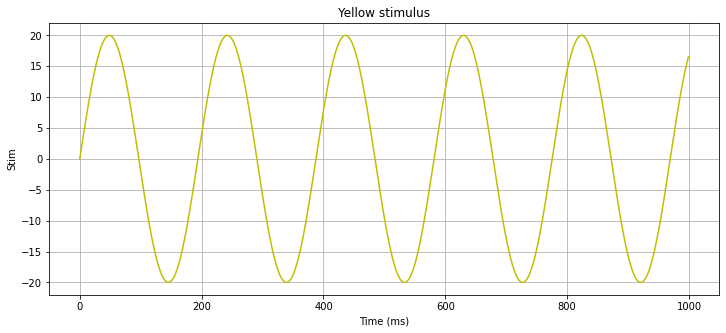

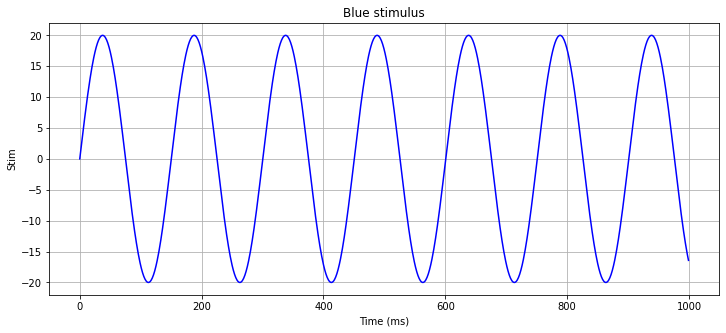

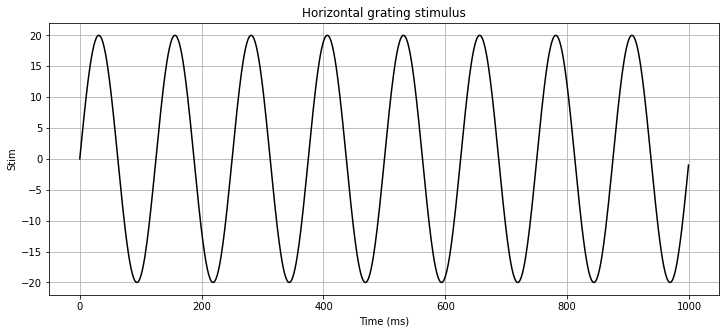

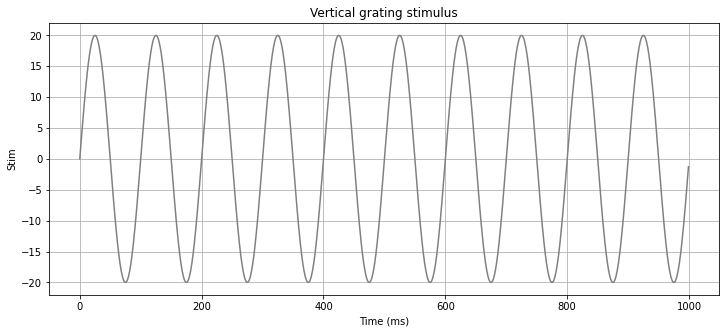

In [ ]:
#Input Stimulus
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(T, Id(T,'yellow'),'y')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Stim')
ax.set_title('Yellow stimulus')
plt.grid()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(T, Id(T,'blue'),'b')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Stim')
ax.set_title('Blue stimulus')
plt.grid()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(T, Id(T,'hgrate'),'black')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Stim')
ax.set_title('Horizontal grating stimulus')
plt.grid()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(T, Id(T,'vgrate'),'grey')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Stim')
ax.set_title('Vertical grating stimulus')
plt.grid()

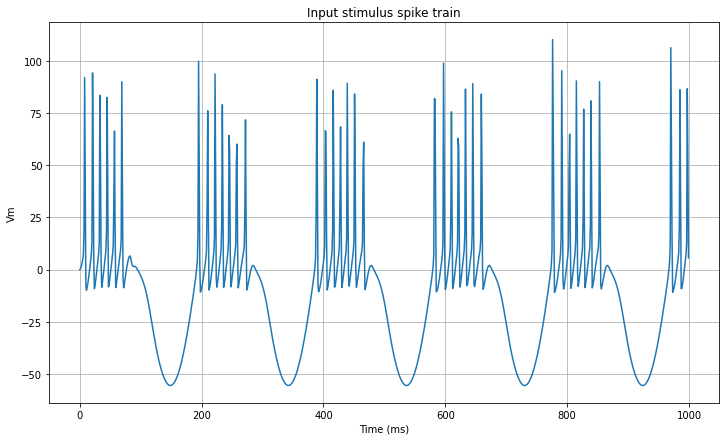

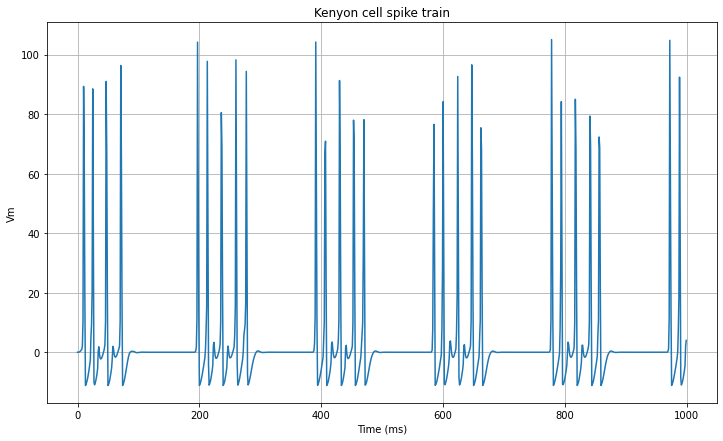

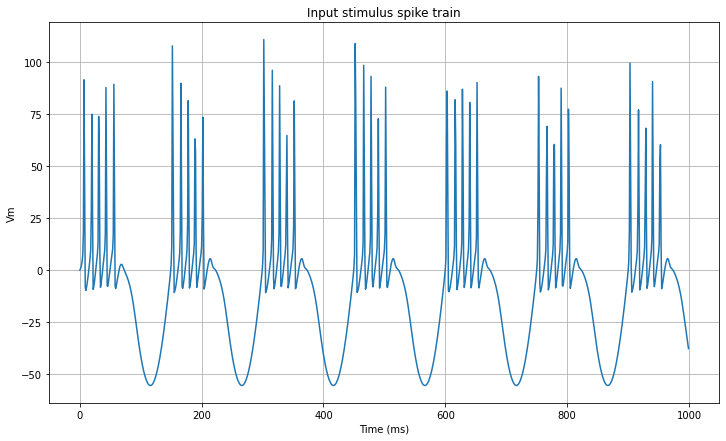

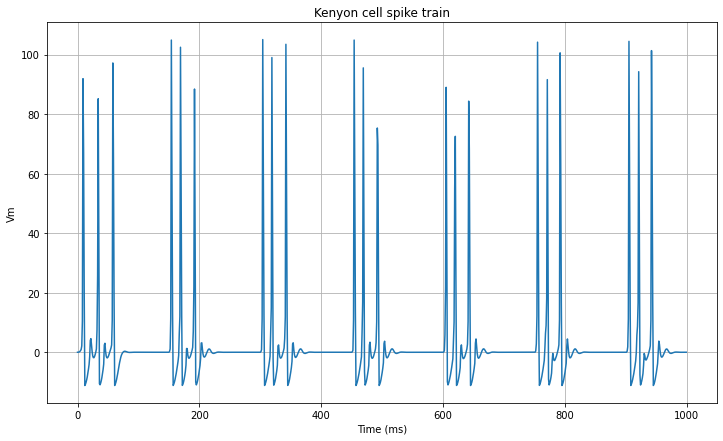

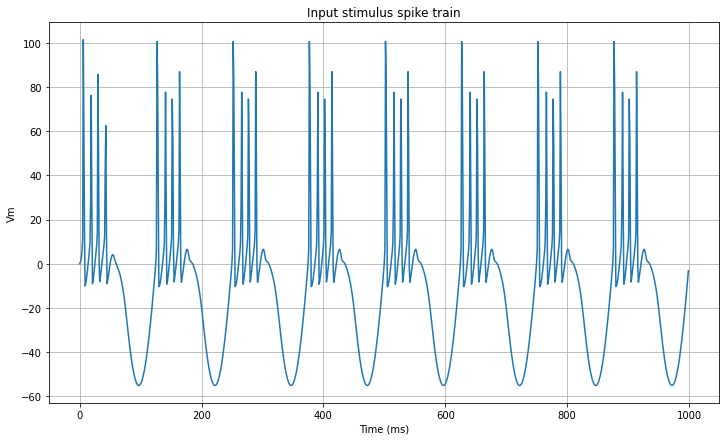

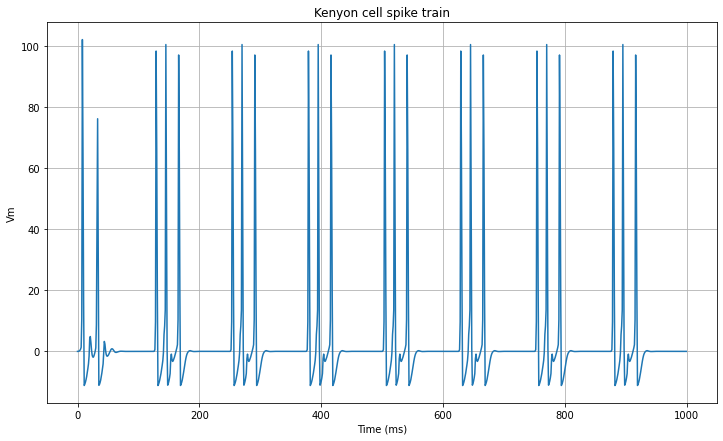

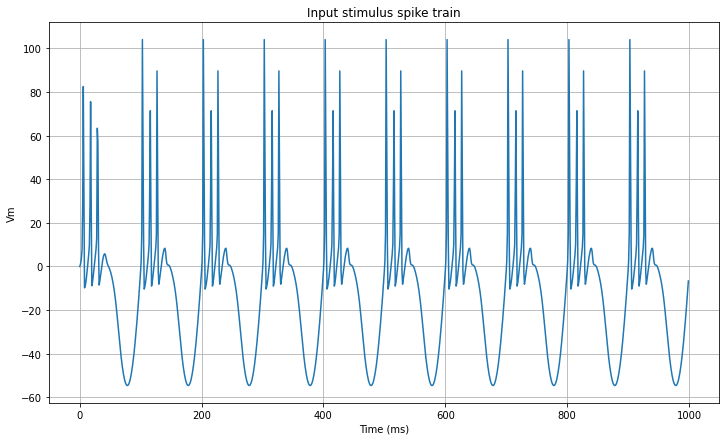

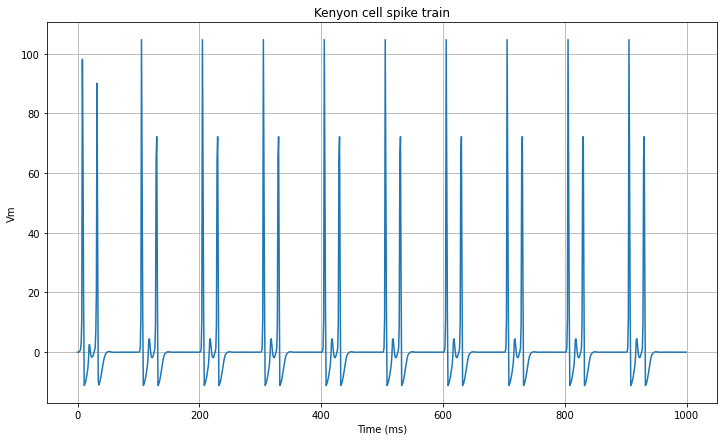

In [ ]:
yellowGTStim = firstStimulus(Y,T,'yellow')

blueGTStim = firstStimulus(Y,T,'blue')

hgrateGTStim = firstStimulus(Y,T,'hgrate')

vgrateGTStim = firstStimulus(Y,T,'vgrate')

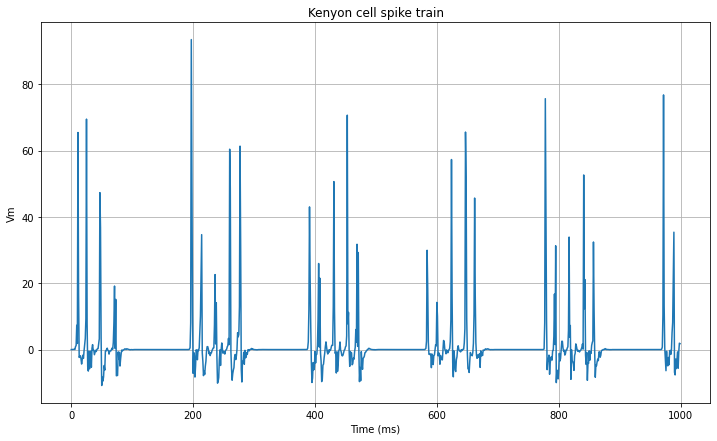

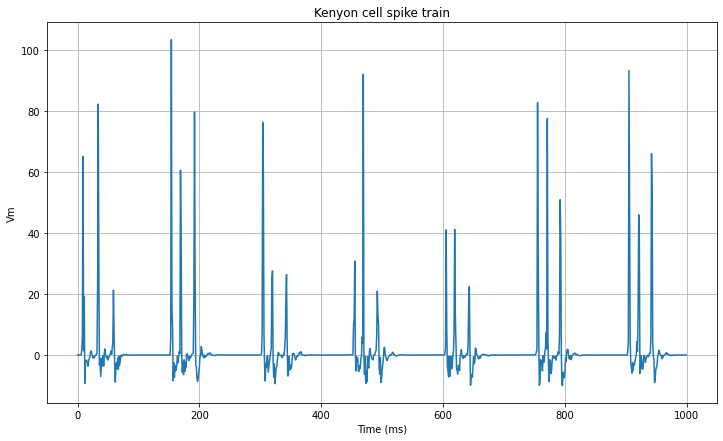

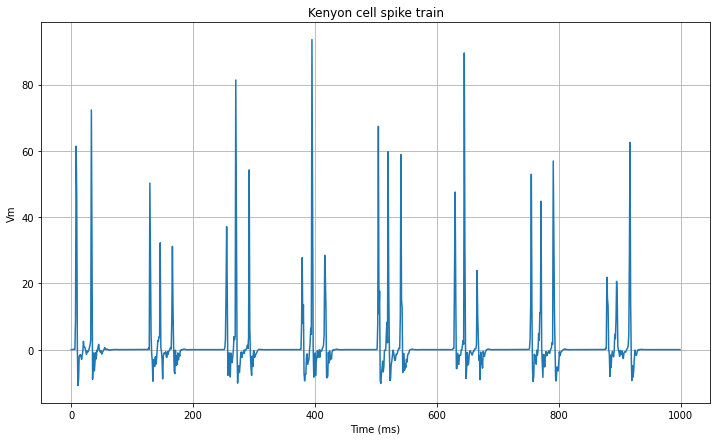

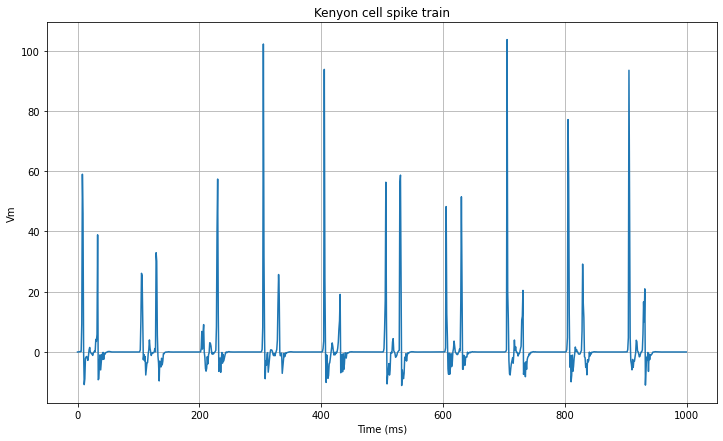

In [ ]:
yellowDelayedStim = delayedStimulus(Y,T,'yellow')
blueDelayedStim = delayedStimulus(Y,T,'blue')
hgrateDelayedStim = delayedStimulus(Y,T,'hgrate')
vgrateDelayedStim = delayedStimulus(Y,T,'vgrate')

In [ ]:
#Sameness Learning:

firstStim='yellow'
sampleStim = ['yellow','blue']

for i in range(1000):
  choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
  print(i,firstStim,choiceStim,np.sum(yellowDelayedStim),np.sum(blueDelayedStim))

  if (firstStim=='yellow'):
    if(choiceStim[0]=='blue'):
      print('noReward')
    
    if(choiceStim[0]=='yellow'):
      blueDelayedStim = blueDelayedStim - InhibitStimulus(Y,T,'blue')
      LearnedInhibitions=blueDelayedStim
      LearnedWeights[i]=noise[i]
      
  if (firstStim=='blue'):
    if(choiceStim[0]=='yellow'):
      print('noReward')
    
    if(choiceStim[0]=='blue'):
      yellowDelayedStim = yellowDelayedStim - InhibitStimulus(Y,T,'yellow')
      LearnedInhibitions=yellowDelayedStim
      LearnedWeights[i]=noise[i]
      
# choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)

0 yellow ['blue'] 1318.9410518567502 1269.7319380001911
noReward
1 yellow ['yellow'] 1318.9410518567502 1269.7319380001911
2 yellow ['yellow'] 1318.9410518567502 1267.9543132869908
3 yellow ['blue'] 1318.9410518567502 1266.1766885737907
noReward
4 yellow ['blue'] 1318.9410518567502 1266.1766885737907
noReward
5 yellow ['yellow'] 1318.9410518567502 1266.1766885737907
6 yellow ['blue'] 1318.9410518567502 1264.39906386059
noReward
7 yellow ['yellow'] 1318.9410518567502 1264.39906386059
8 yellow ['yellow'] 1318.9410518567502 1262.62143914739
9 yellow ['blue'] 1318.9410518567502 1260.8438144341899
noReward
10 yellow ['blue'] 1318.9410518567502 1260.8438144341899
noReward
11 yellow ['blue'] 1318.9410518567502 1260.8438144341899
noReward
12 yellow ['yellow'] 1318.9410518567502 1260.8438144341899
13 yellow ['blue'] 1318.9410518567502 1259.0661897209895
noReward
14 yellow ['yellow'] 1318.9410518567502 1259.0661897209895
15 yellow ['blue'] 1318.9410518567502 1257.2885650077892
noReward
16 yellow

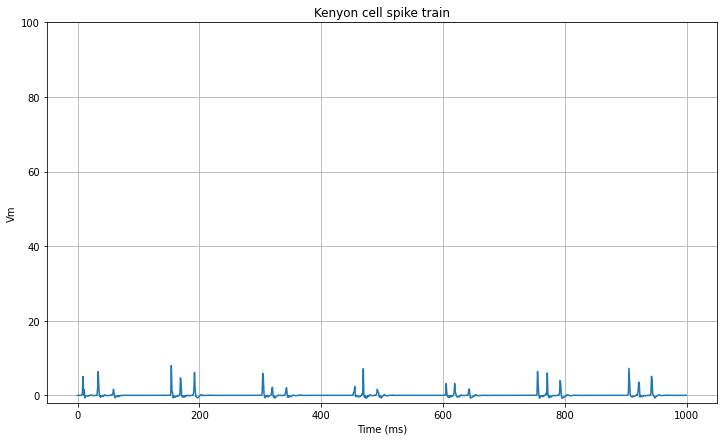

In [ ]:
#After training plot when yellow learnt, blue forgotten
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, blueDelayedStim)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm')
ax.set_ylim([-2,100])
ax.set_title('Kenyon cell spike train')
plt.grid()

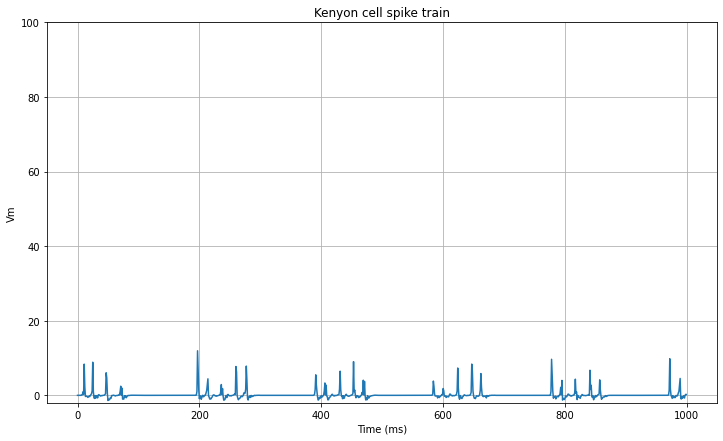

In [ ]:
#After training plot when blue learnt, yellow forgotten
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, yellowDelayedStim)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm')
ax.set_ylim([-2,100])
ax.set_title('Kenyon cell spike train')
plt.grid()

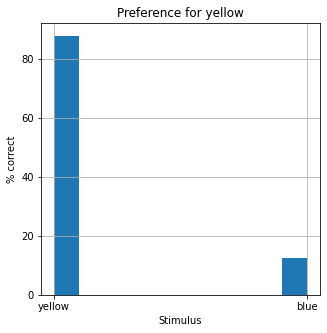

In [ ]:
#For First Stimulus Yellow for sameness learning
choices=[]
sampleStim = ['yellow','blue']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for yellow')
plt.grid()

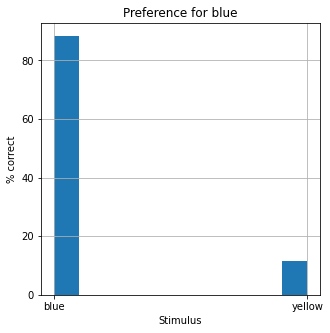

In [ ]:
#For First Stimulus Blue for sameness learning

choices=[]
sampleStim = ['yellow','blue']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for blue')
plt.grid()

In [ ]:
#Difference Learning:

firstStim='yellow'
sampleStim = ['yellow','blue']

for i in range(1000):
  choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
  print(i,firstStim,choiceStim,np.sum(yellowDelayedStim),np.sum(blueDelayedStim))

  if (firstStim=='yellow'):
    if(choiceStim[0]=='yellow'):
      print('noReward')
    
    if(choiceStim[0]=='blue'):
      yellowDelayedStim = yellowDelayedStim - InhibitStimulus(Y,T,'blue')
      LearnedInhibitions=yellowDelayedStim
      LearnedWeights[i]=noise[i]
      
  if (firstStim=='blue'):
    if(choiceStim[0]=='blue'):
      print('noReward')
    
    if(choiceStim[0]=='yellow'):
      blueDelayedStim = blueDelayedStim - InhibitStimulus(Y,T,'yellow')
      LearnedInhibitions=blueDelayedStim
      LearnedWeights[i]=noise[i]
      
# choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)

0 yellow ['yellow'] 1318.9410518567502 1269.7319380001911
noReward
1 yellow ['yellow'] 1318.9410518567502 1269.7319380001911
noReward
2 yellow ['blue'] 1318.9410518567502 1269.7319380001911
3 yellow ['blue'] 1317.16342714355 1269.7319380001911
4 yellow ['blue'] 1315.38580243035 1269.7319380001911
5 yellow ['blue'] 1313.6081777171496 1269.7319380001911
6 yellow ['blue'] 1311.8305530039493 1269.7319380001911
7 yellow ['blue'] 1310.0529282907492 1269.7319380001911
8 yellow ['yellow'] 1308.2753035775486 1269.7319380001911
noReward
9 yellow ['blue'] 1308.2753035775486 1269.7319380001911
10 yellow ['yellow'] 1306.4976788643485 1269.7319380001911
noReward
11 yellow ['yellow'] 1306.4976788643485 1269.7319380001911
noReward
12 yellow ['blue'] 1306.4976788643485 1269.7319380001911
13 yellow ['yellow'] 1304.7200541511484 1269.7319380001911
noReward
14 yellow ['yellow'] 1304.7200541511484 1269.7319380001911
noReward
15 yellow ['blue'] 1304.7200541511484 1269.7319380001911
16 yellow ['blue'] 1302.9

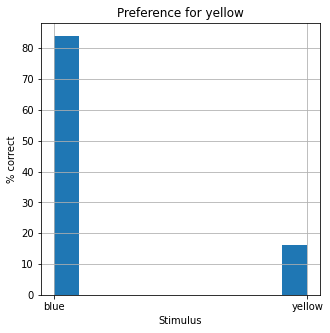

In [ ]:
#For First Stimulus Yellow for difference learning
choices=[]
sampleStim = ['yellow','blue']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for yellow')
plt.grid()

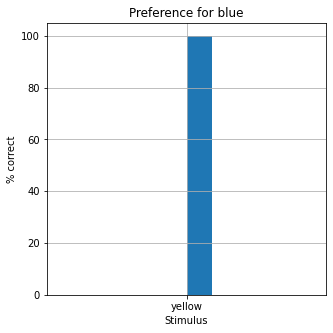

In [ ]:
#For First Stimulus Blue for difference learning
choices=[]
sampleStim = ['yellow','blue']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(yellowDelayedStim), np.sum(blueDelayedStim)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for blue')
plt.grid()

2034.1897826314844 133.66360187885175


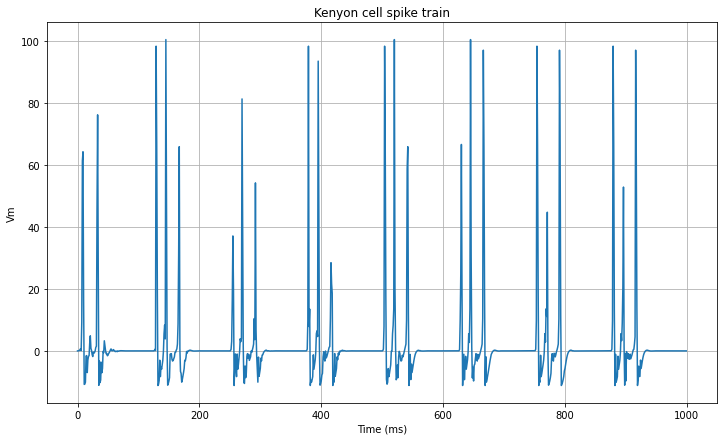

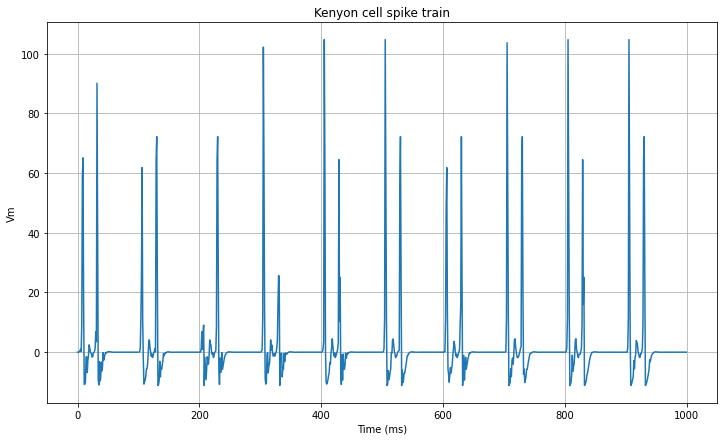

In [ ]:
#Transfer Learning Sameness
hgrateDelayed=[]
vgrateDelayed=[]
firstStim='hgrate'
# LearnedInhibitions[0]=0.3
if (firstStim=='hgrate'):
    # hgratefirst = firstStimulus(Y,T,'hgrate')
    hgrateDelayed = delayedStimulus(Y,T,'hgrate',LearnedWeights)
    vgrateDelayed = delayedStimulus(Y,T,'vgrate')
    vgrateDelayed = vgrateDelayed-LearnedInhibitions*InhibitionConst
if (firstStim=='vgrate'):
    # hgratefirst = firstStimulus(Y,T,'hgrate')
    vgrateDelayed = delayedStimulus(Y,T,'vgrate',LearnedWeights)
    hgrateDelayed = delayedStimulus(Y,T,'hgrate')
    hgrateDelayed = hgrateDelayed-LearnedInhibitions*InhibitionConst

print(np.sum(hgrateDelayed),np.sum(vgrateDelayed))

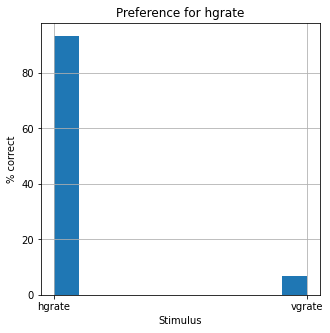

In [ ]:
#For First Stimulus hgrate
choices=[]
sampleStim = ['hgrate','vgrate']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(hgrateDelayed), np.sum(vgrateDelayed)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for hgrate')
plt.grid()

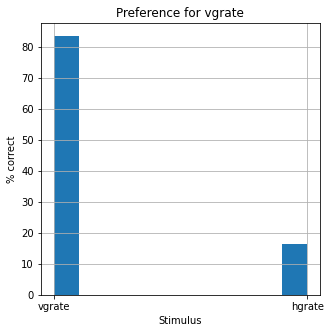

In [ ]:
#For First Stimulus vgrate
choices=[]
sampleStim = ['hgrate','vgrate']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(hgrateDelayed), np.sum(vgrateDelayed)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for vgrate')
plt.grid()

2398.307678924675 78.57573928965269


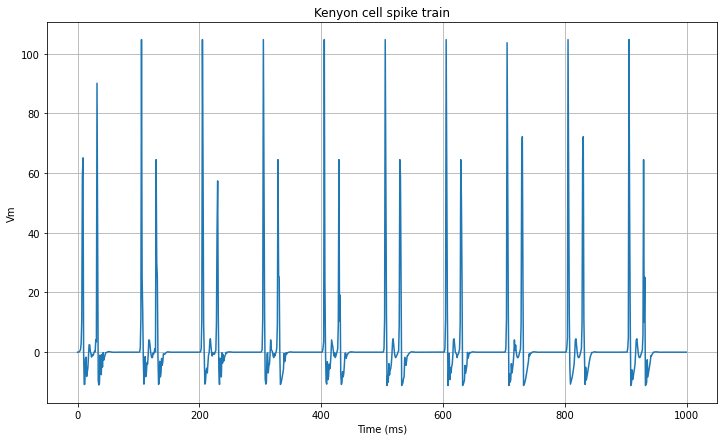

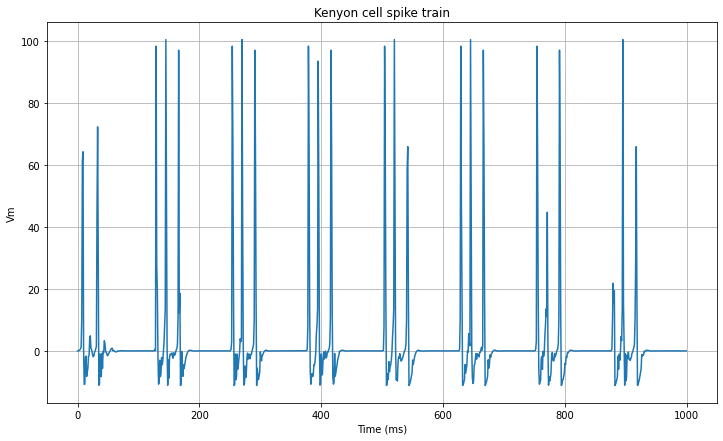

In [ ]:
#Transfer Learning Difference

hgrateDelayed=[]
vgrateDelayed=[]
firstStim='vgrate'
# LearnedInhibitions[0]=0.3
if (firstStim=='hgrate'):
    # hgratefirst = firstStimulus(Y,T,'hgrate')
    hgrateDelayed = delayedStimulus(Y,T,'hgrate')
    vgrateDelayed = delayedStimulus(Y,T,'vgrate',LearnedWeights)
    hgrateDelayed = hgrateDelayed-LearnedInhibitions*InhibitionConst
if (firstStim=='vgrate'):
    # hgratefirst = firstStimulus(Y,T,'hgrate')
    vgrateDelayed = delayedStimulus(Y,T,'vgrate')
    hgrateDelayed = delayedStimulus(Y,T,'hgrate',LearnedWeights)
    vgrateDelayed = vgrateDelayed-LearnedInhibitions*InhibitionConst

print(np.sum(hgrateDelayed),np.sum(vgrateDelayed))

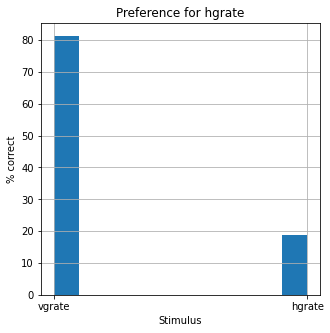

In [ ]:
#For First Stimulus hgrate for difference learning
choices=[]
sampleStim = ['hgrate','vgrate']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(hgrateDelayed), np.sum(vgrateDelayed)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for hgrate')
plt.grid()

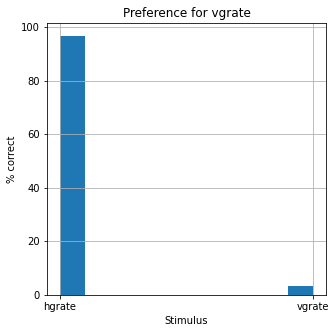

In [ ]:
#For First Stimulus vgrate for difference learning
choices=[]
sampleStim = ['hgrate','vgrate']
for i in range(300):
    choiceStim = random.choices(sampleStim, weights=(np.sum(hgrateDelayed), np.sum(vgrateDelayed)), k=1)
    choices.append(choiceStim[0])
# plt.hist(choices)
# plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(choices, weights=np.ones(len(choices))/len(choices)*100)
ax.set_xlabel('Stimulus')
ax.set_ylabel('% correct')
ax.set_title('Preference for vgrate')
plt.grid()